# PyTorch MNIST Example

The MNIST dataset is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. 

It consists of 60,000 training images and 10,000 testing images.

![MNIST Examples](mnist.png)

## Import all the necesary libraries

In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

cuda = torch.cuda.is_available()
cuda

False

## Download the MNIST Train and Test set & Compute basic data statistics
It is always important to know the shape of the data, as well as the min/max and mean/variance

In [8]:
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train Data]')
print(' - Numpy Shape:', train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

print('\n[Train Labels]')
print(' - Numpy Shape:', train.train_labels.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_labels.size())

[Train Data]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)

[Train Labels]
 - Numpy Shape: (60000,)
 - Tensor Shape: torch.Size([60000])


## Visualize a few training samples
Using the matplotlib.pyplot library, we can visualize our input data.


5


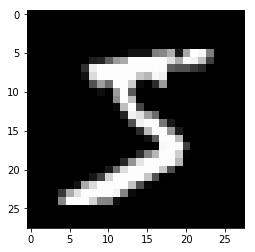

In [10]:
# Visualize a training instance with matplotlib
plt.imshow(train.train_data.cpu().numpy()[0], cmap='gray')
print (train.train_labels.cpu().numpy()[0])

0


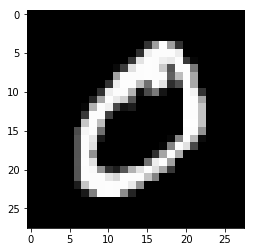

In [12]:
plt.imshow(train.train_data.cpu().numpy()[1], cmap='gray')
print (train.train_labels.cpu().numpy()[1])

## Dataloader

In [13]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].float().reshape(-1) #flatten the input
        Y = self.Y[index].long()
        return X,Y

Using the torch.utils.data DataLoader, we shuffle the data and set the batch size to be 256

In [16]:
num_workers = 8 if cuda else 0 
    
# Training
train_dataset = MyDataset(train.train_data, train.train_labels)

train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Testing
test_dataset = MyDataset(test.test_data, test.test_labels)

test_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

In [17]:
# train_loader = dataloader.DataLoader(train, **train_loader_args) 
# test_loader = dataloader.DataLoader(test, **test_loader_args)

## Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [18]:
# SIMPLE MODEL DEFINITION
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)



## Create the model and define the Loss and Optimizer
We create an instance of our Simple_MLP model by passing it a list of layer sizes. The input layer contains 28*28 = 784 neurons. We define a single hidden layer of size 256, and our output will be the class probabilities for each of the 10 digits (0-9). 

Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using the torch.nn.CrossEntropyLoss.

In order to train our network, we use the torch.optim.SGD optimizer.

In [47]:
model = Simple_MLP([784, 256, 10])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Create a function that will train the network for one epoch

In [48]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

## Create a function that will evaluate our network's performance on the test set

In [49]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc


## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [50]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  0.5763136212230483 Time:  4.145862102508545 s
Testing Loss:  0.19625809053547433
Testing Accuracy:  94.43 %
Training Loss:  0.1751938155754956 Time:  5.156559705734253 s
Testing Loss:  0.175584021463758
Testing Accuracy:  95.16 %
Training Loss:  0.15776814654025673 Time:  5.421808958053589 s
Testing Loss:  0.18851416342736232
Testing Accuracy:  95.23 %
Training Loss:  0.15457237546071798 Time:  5.537095785140991 s
Testing Loss:  0.24893420846906342
Testing Accuracy:  94.36 %
Training Loss:  0.1568650906397425 Time:  5.602488040924072 s
Testing Loss:  0.21554056443896188
Testing Accuracy:  95.92 %
Training Loss:  0.1510263077153392 Time:  5.734762907028198 s
Testing Loss:  0.2701112432783223
Testing Accuracy:  94.99 %
Training Loss:  0.13560212812553257 Time:  5.82598090171814 s
Testing Loss:  0.22949773233752407
Testing Accuracy:  96.12 %
Training Loss:  0.1433399678275574 Time:  5.885256052017212 s
Testing Loss:  0.23259154515831865
Testing Accuracy:  95.91 %
Training 

## Visualize Training Data

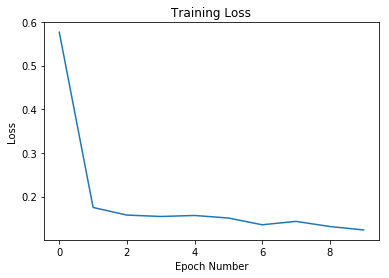

In [51]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

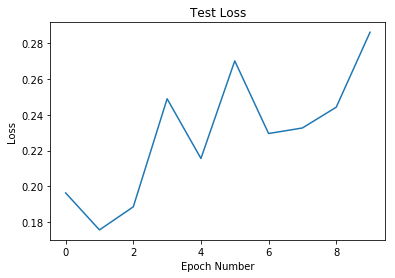

In [52]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)


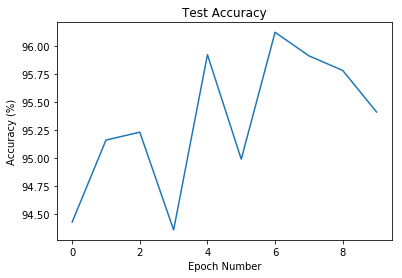

In [53]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)

